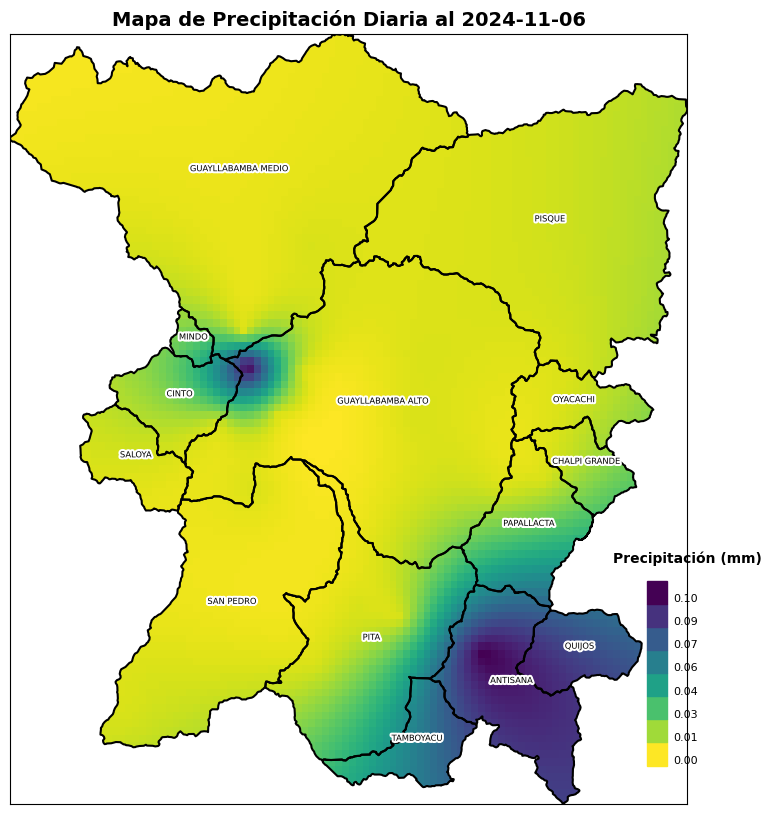

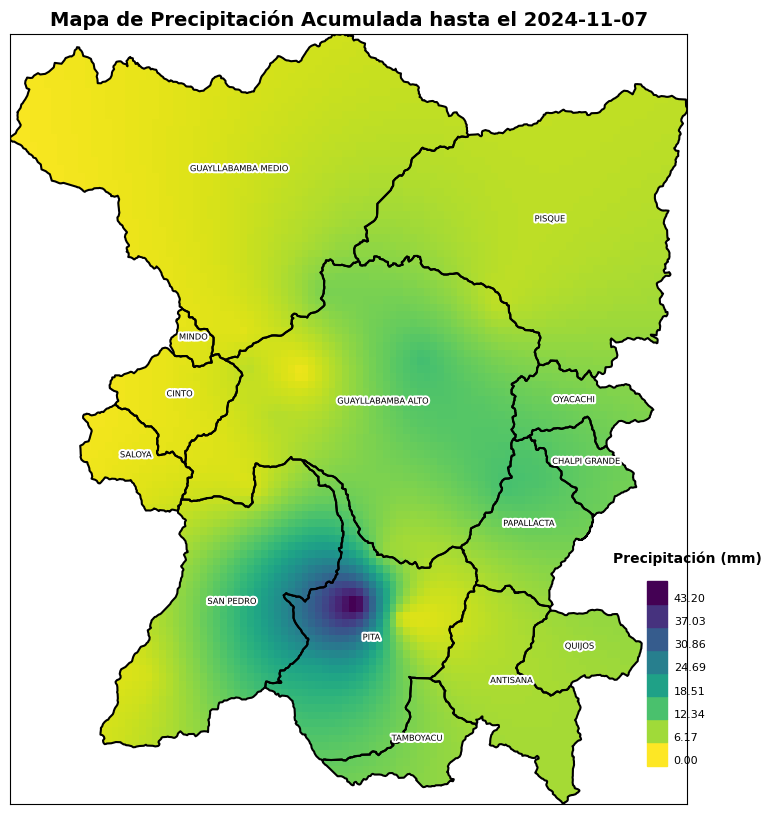

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from metpy.interpolate import interpolate_to_points
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as PathEffects
from shapely.geometry import Polygon
from shapely.ops import unary_union
from datetime import datetime, timedelta

# === Data Loading and Preparation ===

# Load station data
epmaps_stations = pd.read_csv('EPMAPS_stations.csv')
fonag_stations = pd.read_csv('FONAG_stations.csv')

# Combine station data
merged_stations = pd.concat([epmaps_stations, fonag_stations], axis=0)

# Load daily rainfall data
rainfall_data_daily = pd.read_csv('all_stations_daily_rainfall.csv')
rainfall_data_daily['fecha'] = pd.to_datetime(rainfall_data_daily['fecha'])

# Load monthly accumulation data
rainfall_data_monthly = pd.read_csv('all_stations_monthly_accumulation.csv')
rainfall_data_monthly['fecha'] = pd.to_datetime(rainfall_data_monthly['fecha'])

# Merge daily rainfall data with station data
rainfall_with_stations_daily = pd.merge(
    rainfall_data_daily, merged_stations, 
    left_on='station_id', right_on='id_estacion', how='left'
)
rainfall_with_station_info_daily = rainfall_with_stations_daily[
    ['fecha', 'PRECIPITACION SUM', 'station_id', 'punto_obs', 'codigo', 'latitud', 'longitud']
]

# Merge monthly accumulation data with station data
rainfall_with_stations_monthly = pd.merge(
    rainfall_data_monthly, merged_stations, 
    left_on='station_id', right_on='id_estacion', how='left'
)
rainfall_with_station_info_monthly = rainfall_with_stations_monthly[
    ['fecha', 'PRECIPITACION SUM', 'station_id', 'punto_obs', 'codigo', 'latitud', 'longitud']
]

# Load the GeoPackage with polygons
gdf = gpd.read_file('Area.gpkg')

# === Interpolation Function ===

def perform_interpolation(data, provincias_gdf):
    x_min, y_min, x_max, y_max = provincias_gdf.total_bounds
    grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])

    grid_z = interpolate_to_points(
        data[['longitud', 'latitud']].values, 
        data['PRECIPITACION SUM'].values, 
        grid_points, 
        interp_type='rbf', 
        rbf_func='linear', 
        rbf_smooth=0
    ).reshape(grid_x.shape)

    return grid_z, (x_min, y_min, x_max, y_max)

# === Static Plot Function ===

def create_static_plot(grid_z, bounds, provincias_gdf, data, title):
    x_min, y_min, x_max, y_max = bounds

    # Create mask for areas outside the provinces
    large_polygon = Polygon([
        (x_min, y_min), (x_min, y_max), 
        (x_max, y_max), (x_max, y_min)
    ])
    outside_provinces = large_polygon.difference(
        unary_union(provincias_gdf.geometry)
    )
    outside_provinces_gdf = gpd.GeoDataFrame(
        geometry=[outside_provinces], crs="EPSG:4326"
    )

    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the interpolated grid
    plt.imshow(
        grid_z.T, extent=(x_min, x_max, y_min, y_max), 
        origin='lower', cmap='viridis_r'
    )
    
    # Plot areas outside the provinces in white
    outside_provinces_gdf.plot(ax=ax, color='white')
    # Plot province boundaries
    provincias_gdf.boundary.plot(ax=ax, edgecolor='black')
    
    # Create a scale bar
    min_precip = data['PRECIPITACION SUM'].min()
    max_precip = data['PRECIPITACION SUM'].max()
    num_intervals = 8
    scale_values = np.linspace(min_precip, max_precip, num_intervals)
    scale_colors = plt.cm.viridis_r(np.linspace(0, 1, len(scale_values)))

    bar_width, bar_height = 0.03, 0.03
    bar_x = 0.94  # Position of the scale bar
    bar_y_start = 0.05

    # Add scale bar title
    ax.text(
        bar_x - 0.05, bar_y_start + num_intervals * bar_height + 0.02, 
        'Precipitación (mm)', transform=ax.transAxes, 
        verticalalignment='bottom', fontsize=10, fontweight='bold'
    )

    # Draw the scale bar
    for i, value in enumerate(scale_values):
        bar_y = bar_y_start + i * bar_height
        rect = patches.Rectangle(
            (bar_x, bar_y), bar_width, bar_height, 
            transform=ax.transAxes, color=scale_colors[i]
        )
        ax.add_patch(rect)
        ax.text(
            bar_x + bar_width + 0.01, bar_y, f'{value:.2f}', 
            transform=ax.transAxes, verticalalignment='bottom', fontsize=8
        )

    # Annotate province names
    for idx, row in provincias_gdf.iterrows():
        annotation = plt.annotate(
            text=row['NAM'], 
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            xytext=(1,1), textcoords="offset points", 
            ha='center', fontsize='6'
        )
        annotation.set_path_effects([
            PathEffects.withStroke(linewidth=3, foreground='white')
        ])

    # Remove axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Add the plot title
    plt.title(title, fontsize=14, fontweight='bold')

    # Save and display the plot
    plt.savefig(f'{title}.png', dpi=600, bbox_inches='tight', pad_inches=0.1)
    plt.show()

# === Generate Daily Interpolation Map ===

# Get today's and yesterday's dates
today_date = datetime.today()
today_str = today_date.strftime('%Y-%m-%d')
yesterday_date = today_date - timedelta(days=1)
yesterday_str = yesterday_date.strftime('%Y-%m-%d')

# Try to get data for today; if not available, use yesterday
daily_data = rainfall_with_station_info_daily[
    rainfall_with_station_info_daily['fecha'] == today_str
]

if daily_data.empty:
    # If no data for today, use yesterday's data
    daily_data = rainfall_with_station_info_daily[
        rainfall_with_station_info_daily['fecha'] == yesterday_str
    ]
    date_str = yesterday_str
else:
    date_str = today_str

# Check if data is available
if not daily_data.empty:
    # Interpolate rainfall data
    grid_z_daily, bounds_daily = perform_interpolation(daily_data, gdf)
    # Create static plot
    create_static_plot(
        grid_z_daily, bounds_daily, gdf, daily_data, 
        f'Mapa de Precipitación Diaria al {date_str}'
    )
else:
    print(f"No daily data available for {today_str} or {yesterday_str}")

# === Generate Monthly Accumulation Map ===

# Try to get monthly data for today; if not available, use yesterday
monthly_data = rainfall_with_station_info_monthly[
    rainfall_with_station_info_monthly['fecha'] == today_str
]

if monthly_data.empty:
    # If no data for today, use yesterday's data
    monthly_data = rainfall_with_station_info_monthly[
        rainfall_with_station_info_monthly['fecha'] == yesterday_str
    ]
    date_str_monthly = yesterday_str
else:
    date_str_monthly = today_str

# Check if data is available
if not monthly_data.empty:
    # Interpolate rainfall data
    grid_z_monthly, bounds_monthly = perform_interpolation(monthly_data, gdf)
    # Create static plot
    create_static_plot(
        grid_z_monthly, bounds_monthly, gdf, monthly_data, 
        f'Mapa de Precipitación Acumulada hasta el {date_str_monthly}'
    )
else:
    print(f"No monthly data available for {today_str} or {yesterday_str}")


Interactive map saved as Precipitación_Diaria_al_2024-11-06_interactivo.html
Interactive map saved as Precipitación_Acumulada_hasta_el_2024-11-07_interactivo.html


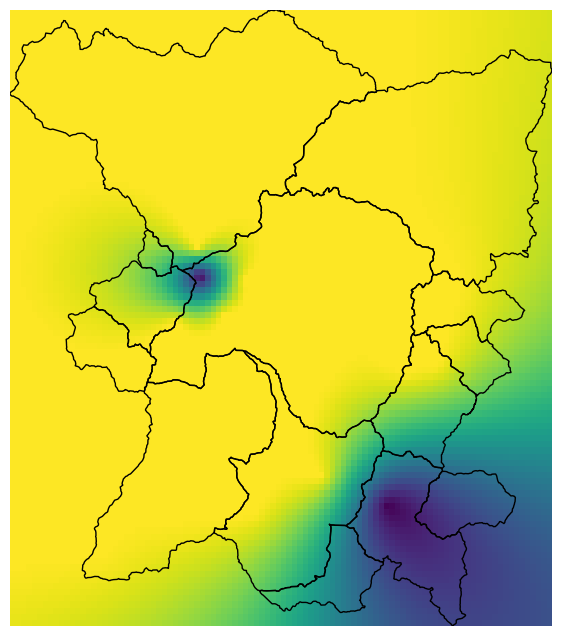

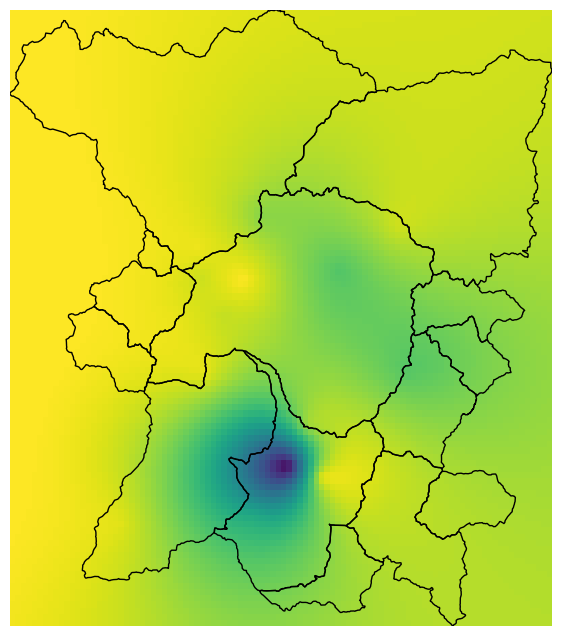

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
from metpy.interpolate import interpolate_to_points
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as PathEffects
from shapely.geometry import Polygon
from shapely.ops import unary_union
from datetime import datetime, timedelta
import folium
from folium.plugins import MeasureControl
import branca.colormap as cm
import base64
from io import BytesIO

# === Data Loading and Preparation ===

# Load station data
epmaps_stations = pd.read_csv('EPMAPS_stations.csv')
fonag_stations = pd.read_csv('FONAG_stations.csv')

# Combine station data
merged_stations = pd.concat([epmaps_stations, fonag_stations], axis=0)

# Load daily rainfall data
rainfall_data_daily = pd.read_csv('all_stations_daily_rainfall.csv')
rainfall_data_daily['fecha'] = pd.to_datetime(rainfall_data_daily['fecha'])

# Load monthly accumulation data
rainfall_data_monthly = pd.read_csv('all_stations_monthly_accumulation.csv')
rainfall_data_monthly['fecha'] = pd.to_datetime(rainfall_data_monthly['fecha'])

# Merge daily rainfall data with station data
rainfall_with_stations_daily = pd.merge(
    rainfall_data_daily, merged_stations, 
    left_on='station_id', right_on='id_estacion', how='left'
)
rainfall_with_station_info_daily = rainfall_with_stations_daily[
    ['fecha', 'PRECIPITACION SUM', 'station_id', 'punto_obs', 'codigo', 'latitud', 'longitud']
]

# Merge monthly accumulation data with station data
rainfall_with_stations_monthly = pd.merge(
    rainfall_data_monthly, merged_stations, 
    left_on='station_id', right_on='id_estacion', how='left'
)
rainfall_with_station_info_monthly = rainfall_with_stations_monthly[
    ['fecha', 'PRECIPITACION SUM', 'station_id', 'punto_obs', 'codigo', 'latitud', 'longitud']
]

# Load the GeoPackage with polygons
gdf = gpd.read_file('Area.gpkg')

# === Interpolation Function ===

def perform_interpolation(data, provincias_gdf):
    x_min, y_min, x_max, y_max = provincias_gdf.total_bounds
    grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])
    
    grid_z = interpolate_to_points(
        data[['longitud', 'latitud']].values, 
        data['PRECIPITACION SUM'].values, 
        grid_points, 
        interp_type='rbf', 
        rbf_func='linear', 
        rbf_smooth=0
    ).reshape(grid_x.shape)
    
    return grid_z, (x_min, y_min, x_max, y_max)

# === Interactive Map Function with Raster Overlay ===

def create_interactive_map_with_raster(grid_z, bounds, provincias_gdf, data, title):
    x_min, y_min, x_max, y_max = bounds
    
    # Create the map centered on the general area of the stations
    m = folium.Map(location=[data['latitud'].mean(), data['longitud'].mean()], zoom_start=10, tiles='CartoDB positron')
    
    # Add the polygon boundaries to the map
    folium.GeoJson(
        provincias_gdf,
        style_function=lambda feature: {
            'color': 'black',
            'weight': 2,
            'fillOpacity': 0,
        }
    ).add_to(m)
    
    # Add a scale bar
    m.add_child(MeasureControl())
    
    # Define the colormap
    min_rainfall = data['PRECIPITACION SUM'].min()
    max_rainfall = data['PRECIPITACION SUM'].max()
    colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow', 'orange', 'red'], vmin=min_rainfall, vmax=max_rainfall)
    
    # Create an image of the interpolated grid
    fig, ax = plt.subplots(figsize=(8, 8))
    # Remove axes for cleaner image
    ax.axis('off')
    
    # Plot the raster grid
    im = ax.imshow(
        grid_z.T, extent=(x_min, x_max, y_min, y_max), 
        origin='lower', cmap='viridis_r', 
        vmin=min_rainfall, vmax=max_rainfall
    )
    
    # Overlay province boundaries
    provincias_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
    
    # Save the image to a BytesIO object
    img_data = BytesIO()
    plt.savefig(img_data, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
    img_data.seek(0)
    
    # Encode the image in base64
    img_base64 = base64.b64encode(img_data.read()).decode('utf-8')
    img_url = 'data:image/png;base64,{}'.format(img_base64)
    
    # Add the image overlay to the map
    img_overlay = folium.raster_layers.ImageOverlay(
        image=img_url,
        bounds=[[y_min, x_min], [y_max, x_max]],
        opacity=0.6,
        interactive=True,
        cross_origin=False,
        zindex=1,
    )
    img_overlay.add_to(m)
    
    # Add rainfall data as markers
    for _, row in data.iterrows():
        folium.CircleMarker(
            location=[row['latitud'], row['longitud']],
            radius=5,
            popup=f"Estación: {row['punto_obs']}<br>Precipitación: {row['PRECIPITACION SUM']} mm",
            color='black',
            fill=True,
            fill_color=colormap(row['PRECIPITACION SUM']),
            fill_opacity=1,
        ).add_to(m)
    
    # Add the color scale bar to the map
    colormap.caption = 'Precipitación (mm)'
    colormap.add_to(m)
    
    # Add a title using folium's HTML feature
    title_html = f'''
        <h3 align="center" style="font-size:20px"><b>{title}</b></h3>
        '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Save the map as an HTML file
    map_filename = f'{title.replace(" ", "_")}_interactivo.html'
    m.save(map_filename)
    
    print(f"Interactive map saved as {map_filename}")

# === Generate Daily Interpolation Map with Raster Overlay ===

# Get today's and yesterday's dates
today_date = datetime.today()
today_str = today_date.strftime('%Y-%m-%d')
yesterday_date = today_date - timedelta(days=1)
yesterday_str = yesterday_date.strftime('%Y-%m-%d')

# Try to get data for today; if not available, use yesterday
daily_data = rainfall_with_station_info_daily[
    rainfall_with_station_info_daily['fecha'] == today_str
]

if daily_data.empty:
    # If no data for today, use yesterday's data
    daily_data = rainfall_with_station_info_daily[
        rainfall_with_station_info_daily['fecha'] == yesterday_str
    ]
    date_str = yesterday_str
else:
    date_str = today_str

# Check if data is available
if not daily_data.empty:
    # Interpolate rainfall data
    grid_z_daily, bounds_daily = perform_interpolation(daily_data, gdf)
    # Create interactive map with raster overlay
    create_interactive_map_with_raster(
        grid_z_daily, bounds_daily, gdf, daily_data, 
        f'Precipitación Diaria al {date_str}'
    )
else:
    print(f"No daily data available for {today_str} or {yesterday_str}")

# === Generate Monthly Accumulation Map with Raster Overlay ===

# Try to get monthly data for today; if not available, use yesterday
monthly_data = rainfall_with_station_info_monthly[
    rainfall_with_station_info_monthly['fecha'] == today_str
]

if monthly_data.empty:
    # If no data for today, use yesterday's data
    monthly_data = rainfall_with_station_info_monthly[
        rainfall_with_station_info_monthly['fecha'] == yesterday_str
    ]
    date_str_monthly = yesterday_str
else:
    date_str_monthly = today_str

# Check if data is available
if not monthly_data.empty:
    # Interpolate rainfall data
    grid_z_monthly, bounds_monthly = perform_interpolation(monthly_data, gdf)
    # Create interactive map with raster overlay
    create_interactive_map_with_raster(
        grid_z_monthly, bounds_monthly, gdf, monthly_data, 
        f'Precipitación Acumulada hasta el {date_str_monthly}'
    )
else:
    print(f"No monthly data available for {today_str} or {yesterday_str}")


Interactive map saved as Precipitación_Diaria_al_2024-11-06_interactivo.html
Interactive map saved as Precipitación_Acumulada_hasta_el_2024-11-07_interactivo.html


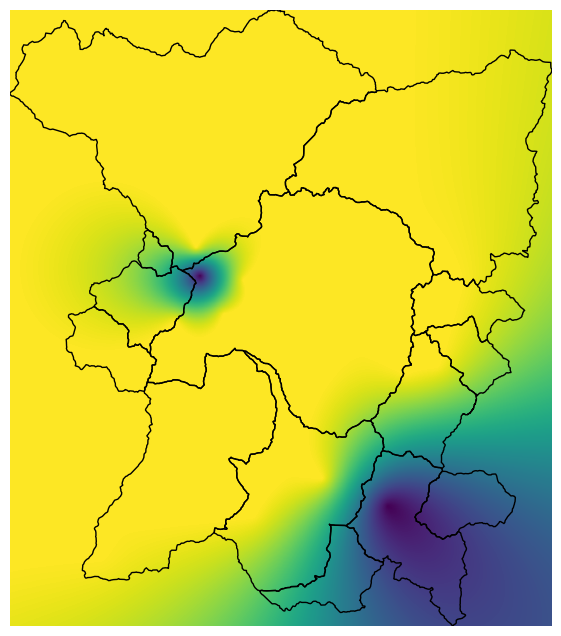

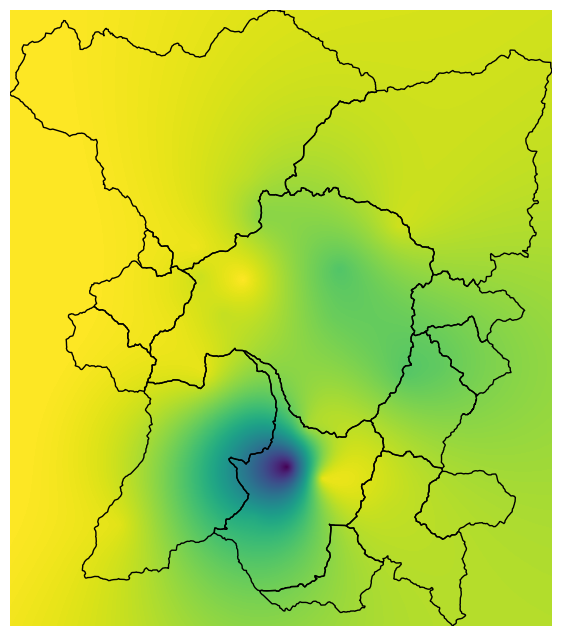

In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
from metpy.interpolate import interpolate_to_points
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.ops import unary_union
from datetime import datetime, timedelta
import folium
from folium.plugins import MeasureControl
import branca.colormap as cm
import base64
from io import BytesIO
import json

# === Data Loading and Preparation ===

# Load station data
epmaps_stations = pd.read_csv('EPMAPS_stations.csv')
fonag_stations = pd.read_csv('FONAG_stations.csv')

# Combine station data
merged_stations = pd.concat([epmaps_stations, fonag_stations], axis=0)

# Load daily rainfall data
rainfall_data_daily = pd.read_csv('all_stations_daily_rainfall.csv')
rainfall_data_daily['fecha'] = pd.to_datetime(rainfall_data_daily['fecha'])

# Load monthly accumulation data
rainfall_data_monthly = pd.read_csv('all_stations_monthly_accumulation.csv')
rainfall_data_monthly['fecha'] = pd.to_datetime(rainfall_data_monthly['fecha'])

# Merge daily rainfall data with station data
rainfall_with_stations_daily = pd.merge(
    rainfall_data_daily, merged_stations, 
    left_on='station_id', right_on='id_estacion', how='left'
)
rainfall_with_station_info_daily = rainfall_with_stations_daily[
    ['fecha', 'PRECIPITACION SUM', 'station_id', 'punto_obs', 'codigo', 'latitud', 'longitud']
]

# Merge monthly accumulation data with station data
rainfall_with_stations_monthly = pd.merge(
    rainfall_data_monthly, merged_stations, 
    left_on='station_id', right_on='id_estacion', how='left'
)
rainfall_with_station_info_monthly = rainfall_with_stations_monthly[
    ['fecha', 'PRECIPITACION SUM', 'station_id', 'punto_obs', 'codigo', 'latitud', 'longitud']
]

# Load the GeoPackage with polygons
gdf = gpd.read_file('Area.gpkg')

# === Interpolation Function ===

def perform_interpolation(data, provincias_gdf):
    x_min, y_min, x_max, y_max = provincias_gdf.total_bounds
    grid_resolution = 500  # Adjust grid resolution as needed
    grid_x, grid_y = np.mgrid[
        x_min:x_max:complex(0, grid_resolution), 
        y_min:y_max:complex(0, grid_resolution)
    ]
    grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])
    
    grid_z = interpolate_to_points(
        data[['longitud', 'latitud']].values, 
        data['PRECIPITACION SUM'].values, 
        grid_points, 
        interp_type='rbf', 
        rbf_func='linear', 
        rbf_smooth=0
    ).reshape(grid_x.shape)
    
    return grid_z, (x_min, y_min, x_max, y_max), grid_x, grid_y

# === Interactive Map Function with Clickable Raster ===

def create_interactive_map_with_raster(grid_z, bounds, grid_x, grid_y, provincias_gdf, data, title):
    x_min, y_min, x_max, y_max = bounds
    
    # Create the map centered on the general area of the stations
    m = folium.Map(location=[data['latitud'].mean(), data['longitud'].mean()], zoom_start=10, tiles='CartoDB positron')
    
    # Add the polygon boundaries to the map
    folium.GeoJson(
        provincias_gdf,
        style_function=lambda feature: {
            'color': 'black',
            'weight': 2,
            'fillOpacity': 0,
        }
    ).add_to(m)
    
    # Add a scale bar
    m.add_child(MeasureControl())
    
    # Define the colormap
    min_rainfall = data['PRECIPITACION SUM'].min()
    max_rainfall = data['PRECIPITACION SUM'].max()
    colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow', 'orange', 'red'], vmin=min_rainfall, vmax=max_rainfall)
    
    # Create an image of the interpolated grid
    fig, ax = plt.subplots(figsize=(8, 8))
    # Remove axes for cleaner image
    ax.axis('off')
    
    # Plot the raster grid
    im = ax.imshow(
        grid_z.T, extent=(x_min, x_max, y_min, y_max), 
        origin='lower', cmap='viridis_r', 
        vmin=min_rainfall, vmax=max_rainfall
    )
    
    # Overlay province boundaries
    provincias_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
    
    # Save the image to a BytesIO object
    img_data = BytesIO()
    plt.savefig(img_data, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
    img_data.seek(0)
    
    # Encode the image in base64
    img_base64 = base64.b64encode(img_data.read()).decode('utf-8')
    img_url = 'data:image/png;base64,{}'.format(img_base64)
    
    # Add the image overlay to the map
    img_overlay = folium.raster_layers.ImageOverlay(
        image=img_url,
        bounds=[[y_min, x_min], [y_max, x_max]],
        opacity=0.6,
        interactive=True,
        cross_origin=False,
        zindex=1,
        name='Precipitación',
    )
    img_overlay.add_to(m)
    
    # Add rainfall data as markers
    for _, row in data.iterrows():
        folium.CircleMarker(
            location=[row['latitud'], row['longitud']],
            radius=5,
            popup=f"Estación: {row['punto_obs']}<br>Precipitación: {row['PRECIPITACION SUM']} mm",
            color='black',
            fill=True,
            fill_color=colormap(row['PRECIPITACION SUM']),
            fill_opacity=1,
        ).add_to(m)
    
    # Add the color scale bar to the map
    colormap.caption = 'Precipitación (mm)'
    colormap.add_to(m)
    
    # Add a title using folium's HTML feature
    title_html = f'''
        <h3 align="center" style="font-size:20px"><b>{title}</b></h3>
        '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    # --- Pass grid data to JavaScript ---
    
    # Convert grid_z to a list for JSON serialization
    grid_z_list = grid_z.tolist()
    grid_x_list = grid_x[:,0].tolist()  # X coordinates (longitude), take first column
    grid_y_list = grid_y[0,:].tolist()  # Y coordinates (latitude), take first row
    
    # Prepare the JavaScript code
    click_js = f'''
    // Grid data
    var gridZ = {json.dumps(grid_z_list)};
    var gridX = {json.dumps(grid_x_list)};
    var gridY = {json.dumps(grid_y_list)};
    
    function getValueAtLatLng(lat, lng) {{
        // Find the closest indices in the grid
        function closestIndex(array, value) {{
            var closest = array.reduce(function(prev, curr) {{
                return (Math.abs(curr - value) < Math.abs(prev - value) ? curr : prev);
            }});
            return array.indexOf(closest);
        }}
        
        var i = closestIndex(gridX, lng);
        var j = closestIndex(gridY, lat);
        
        var precipValue = gridZ[i][j];
        
        if (precipValue === null || isNaN(precipValue)) {{
            alert('No data at this location.');
        }} else {{
            alert('Precipitación estimada: ' + precipValue.toFixed(2) + ' mm');
        }}
    }}
    
    map.on('click', function(e) {{
        var lat = e.latlng.lat;
        var lng = e.latlng.lng;
        getValueAtLatLng(lat, lng);
    }});
    '''
    
    # Add the JavaScript code to the map
    from folium import MacroElement
    from jinja2 import Template
    
    class ClickForValue(MacroElement):
        def __init__(self):
            super().__init__()
            self._template = Template(f'''
                <script>
                    {click_js}
                </script>
            ''')
    
    m.get_root().add_child(ClickForValue())
    
    # Save the map as an HTML file
    map_filename = f'{title.replace(" ", "_")}_interactivo.html'
    m.save(map_filename)
    
    print(f"Interactive map saved as {map_filename}")

# === Generate Daily Interpolation Map with Raster Overlay ===

# Get today's and yesterday's dates
today_date = datetime.today()
today_str = today_date.strftime('%Y-%m-%d')
yesterday_date = today_date - timedelta(days=1)
yesterday_str = yesterday_date.strftime('%Y-%m-%d')

# Try to get data for today; if not available, use yesterday
daily_data = rainfall_with_station_info_daily[
    rainfall_with_station_info_daily['fecha'] == today_str
]

if daily_data.empty:
    # If no data for today, use yesterday's data
    daily_data = rainfall_with_station_info_daily[
        rainfall_with_station_info_daily['fecha'] == yesterday_str
    ]
    date_str = yesterday_str
else:
    date_str = today_str

# Check if data is available
if not daily_data.empty:
    # Interpolate rainfall data
    grid_z_daily, bounds_daily, grid_x_daily, grid_y_daily = perform_interpolation(daily_data, gdf)
    # Create interactive map with raster overlay and clickable values
    create_interactive_map_with_raster(
        grid_z_daily, bounds_daily, grid_x_daily, grid_y_daily, gdf, daily_data, 
        f'Precipitación Diaria al {date_str}'
    )
else:
    print(f"No daily data available for {today_str} or {yesterday_str}")

# === Generate Monthly Accumulation Map with Raster Overlay ===

# Try to get monthly data for today; if not available, use yesterday
monthly_data = rainfall_with_station_info_monthly[
    rainfall_with_station_info_monthly['fecha'] == today_str
]

if monthly_data.empty:
    # If no data for today, use yesterday's data
    monthly_data = rainfall_with_station_info_monthly[
        rainfall_with_station_info_monthly['fecha'] == yesterday_str
    ]
    date_str_monthly = yesterday_str
else:
    date_str_monthly = today_str

# Check if data is available
if not monthly_data.empty:
    # Interpolate rainfall data
    grid_z_monthly, bounds_monthly, grid_x_monthly, grid_y_monthly = perform_interpolation(monthly_data, gdf)
    # Create interactive map with raster overlay and clickable values
    create_interactive_map_with_raster(
        grid_z_monthly, bounds_monthly, grid_x_monthly, grid_y_monthly, gdf, monthly_data, 
        f'Precipitación Acumulada hasta el {date_str_monthly}'
    )
else:
    print(f"No monthly data available for {today_str} or {yesterday_str}")


In [10]:
import pandas as pd
import geopandas as gpd
import numpy as np
from metpy.interpolate import interpolate_to_points
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
from datetime import datetime, timedelta
import folium
from folium.plugins import MeasureControl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import base64
import io
import json

# === Data Loading and Preparation ===

# Load station data
epmaps_stations = pd.read_csv('EPMAPS_stations.csv')
fonag_stations = pd.read_csv('FONAG_stations.csv')

# Combine station data
merged_stations = pd.concat([epmaps_stations, fonag_stations], axis=0)

# Load daily rainfall data
rainfall_data_daily = pd.read_csv('all_stations_daily_rainfall.csv')
rainfall_data_daily['fecha'] = pd.to_datetime(rainfall_data_daily['fecha'])

# Load monthly accumulation data
rainfall_data_monthly = pd.read_csv('all_stations_monthly_accumulation.csv')
rainfall_data_monthly['fecha'] = pd.to_datetime(rainfall_data_monthly['fecha'])

# Merge daily rainfall data with station data
rainfall_with_stations_daily = pd.merge(
    rainfall_data_daily, merged_stations,
    left_on='station_id', right_on='id_estacion', how='left'
)
rainfall_with_station_info_daily = rainfall_with_stations_daily[
    ['fecha', 'PRECIPITACION SUM', 'station_id', 'punto_obs', 'codigo', 'latitud', 'longitud']
]

# Merge monthly accumulation data with station data
rainfall_with_stations_monthly = pd.merge(
    rainfall_data_monthly, merged_stations,
    left_on='station_id', right_on='id_estacion', how='left'
)
rainfall_with_station_info_monthly = rainfall_with_stations_monthly[
    ['fecha', 'PRECIPITACION SUM', 'station_id', 'punto_obs', 'codigo', 'latitud', 'longitud']
]

# Load the GeoPackage with polygons
gdf = gpd.read_file('Area.gpkg')

# === Interpolation Function ===

def perform_interpolation(data, provincias_gdf, grid_resolution=500):
    x_min, y_min, x_max, y_max = provincias_gdf.total_bounds
    grid_x, grid_y = np.mgrid[
        x_min:x_max:complex(0, grid_resolution),
        y_min:y_max:complex(0, grid_resolution)
    ]
    grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])

    # Perform interpolation
    grid_z = interpolate_to_points(
        data[['longitud', 'latitud']].values,
        data['PRECIPITACION SUM'].values,
        grid_points,
        interp_type='rbf',
        rbf_func='linear',
        rbf_smooth=0
    ).reshape(grid_x.shape)

    # Mask the grid outside the province boundaries
    x_coords = grid_x[:, 0]
    y_coords = grid_y[0, :]
    x_mesh, y_mesh = np.meshgrid(x_coords, y_coords, indexing='ij')
    x_flat = x_mesh.flatten()
    y_flat = y_mesh.flatten()
    points = np.vstack((x_flat, y_flat)).T
    polygon = unary_union(provincias_gdf.geometry)
    mask_flat = ~np.array([polygon.contains(Point(x, y)) for x, y in points])
    mask = mask_flat.reshape(grid_z.shape)
    # Set the values outside the province to np.nan
    grid_z[mask] = np.nan

    return grid_z, (x_min, y_min, x_max, y_max), grid_x, grid_y

def create_image_from_grid(grid_z, min_value, max_value):
    # Normalize grid_z to 0-1
    norm_grid = (grid_z - min_value) / (max_value - min_value)
    # Handle NaN values
    norm_grid = np.ma.masked_invalid(norm_grid)

    # Apply colormap
    colormap = cm.get_cmap('viridis')
    image = colormap(norm_grid)  # This returns an RGBA image

    # Convert to uint8
    image_uint8 = (image * 255).astype(np.uint8)

    return image_uint8

def create_interactive_map_with_image_overlay(grid_z, bounds, grid_x, grid_y, provincias_gdf, data, title):
    x_min, y_min, x_max, y_max = bounds
    min_value = np.nanmin(grid_z)
    max_value = np.nanmax(grid_z)

    # Create the image from grid_z
    image = create_image_from_grid(grid_z, min_value, max_value)

    # Save the image to a BytesIO object
    img_data = io.BytesIO()
    plt.imsave(img_data, image, format='png', origin='lower')
    img_data.seek(0)
    img_base64 = base64.b64encode(img_data.read()).decode('utf-8')
    img_url = 'data:image/png;base64,{}'.format(img_base64)

    # Create the map
    m = folium.Map(
        location=[data['latitud'].mean(), data['longitud'].mean()],
        zoom_start=10,
        tiles='CartoDB positron',
        control_scale=True
    )

    # Add the image overlay to the map
    img_overlay = folium.raster_layers.ImageOverlay(
        image=img_url,
        bounds=[[y_min, x_min], [y_max, x_max]],
        opacity=0.7,
        interactive=True,
        cross_origin=False,
        zindex=1,
        name='Interpolated Precipitation',
    )
    img_overlay.add_to(m)

    # Add the polygon boundaries to the map
    folium.GeoJson(
        provincias_gdf,
        style_function=lambda feature: {
            'color': 'black',
            'weight': 2,
            'fillOpacity': 0,
        }
    ).add_to(m)

    # Add rainfall data as markers
    colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow', 'orange', 'red'], vmin=min_value, vmax=max_value)
    for _, row in data.iterrows():
        folium.CircleMarker(
            location=[row['latitud'], row['longitud']],
            radius=5,
            popup=f"Estación: {row['punto_obs']}<br>Precipitación: {row['PRECIPITACION SUM']} mm",
            color='black',
            fill=True,
            fill_color=colormap(row['PRECIPITACION SUM']),
            fill_opacity=1,
        ).add_to(m)

    # Add the color scale bar to the map
    colormap.caption = 'Precipitación (mm)'
    colormap.add_to(m)

    # Add a title using folium's HTML feature
    title_html = f'''
        <h3 align="center" style="font-size:20px"><b>{title}</b></h3>
        '''
    m.get_root().html.add_child(folium.Element(title_html))

    # Pass grid data and bounds to JavaScript
    grid_data = {
        'grid_z': grid_z.T.tolist(),  # Transpose to match image orientation
        'x_min': x_min,
        'x_max': x_max,
        'y_min': y_min,
        'y_max': y_max,
        'grid_width': grid_z.shape[1],
        'grid_height': grid_z.shape[0],
    }
    grid_json = json.dumps(grid_data)

    # JavaScript code to handle clicks
    click_js = f'''
    <script>
        var gridData = {grid_json};

        function getValueAtLatLng(lat, lng) {{
            var x = Math.round((lng - gridData.x_min) / (gridData.x_max - gridData.x_min) * (gridData.grid_width - 1));
            var y = gridData.grid_height - 1 - Math.round((lat - gridData.y_min) / (gridData.y_max - gridData.y_min) * (gridData.grid_height - 1));

            if (x >= 0 && x < gridData.grid_width && y >= 0 && y < gridData.grid_height) {{
                var value = gridData.grid_z[y][x];
                if (value === null || isNaN(value)) {{
                    alert('No data at this location.');
                }} else {{
                    alert('Precipitación estimada: ' + value.toFixed(2) + ' mm');
                }}
            }} else {{
                alert('Location out of bounds.');
            }}
        }}

        map.on('click', function(e) {{
            var lat = e.latlng.lat;
            var lng = e.latlng.lng;
            getValueAtLatLng(lat, lng);
        }});
    </script>
    '''

    # Add the JavaScript code to the map
    m.get_root().html.add_child(folium.Element(click_js))

    # Save the map
    map_filename = f'{title.replace(" ", "_")}_interactivo.html'
    m.save(map_filename)

    print(f"Interactive map saved as {map_filename}")

# === Generate Daily Interpolation Map ===

# [Your code to get daily_data remains the same]

# Perform interpolation and create the map
if not daily_data.empty:
    grid_z_daily, bounds_daily, grid_x_daily, grid_y_daily = perform_interpolation(daily_data, gdf)
    create_interactive_map_with_image_overlay(
        grid_z_daily, bounds_daily, grid_x_daily, grid_y_daily, gdf, daily_data,
        f'Precipitación Diaria al {date_str}'
    )
else:
    print(f"No daily data available for {today_str} or {yesterday_str}")

# === Generate Monthly Accumulation Map ===

# [Your code to get monthly_data remains the same]

# Perform interpolation and create the map
if not monthly_data.empty:
    grid_z_monthly, bounds_monthly, grid_x_monthly, grid_y_monthly = perform_interpolation(monthly_data, gdf)
    create_interactive_map_with_image_overlay(
        grid_z_monthly, bounds_monthly, grid_x_monthly, grid_y_monthly, gdf, monthly_data,
        f'Precipitación Acumulada hasta el {date_str_monthly}'
    )
else:
    print(f"No monthly data available for {today_str} or {yesterday_str}")


C:\Users\U$ER\AppData\Local\Temp\ipykernel_23764\997356984.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


AttributeError: module 'matplotlib.cm' has no attribute 'LinearColormap'